#  Self-Study 5 : Coupled Dynamics and Stability

In this self-study, we will explore the concepts of stability and coupled dynamics. A key part of our approach will involve using symbolic mathematics.

If you are not familiar with `sympy`, take a look at the notebook `sympy_basics.ipynb` for a quick introduction.
This notebook also contains examples on how to use `sympy` to compute the Jacobian matrix of a system of differential equations.

## Section 1: Fixed Points and Phase Portrait

In this section we will be looking at the dynamics of a system of ODEs with **two coupled** variables, $x$ and $y$.

$$
\frac{dx}{dt} = \alpha x - \beta x^2 - \gamma xy
$$
$$
\frac{dy}{dt} = \delta y - y^2 - xy
$$


### Task 1: Find the fixed points analytically (with `sympy`)


The fixed points are the points where the derivatives are zero.
In other words, if the system starts at such a point, it will remain fixed there unless perturbed.

In [1]:
from sympy import symbols, Eq, solve

# Declare variables
x, y = symbols('x y')
alpha, beta, gamma, delta = symbols('alpha beta gamma delta')

# Define the equations for dx/dt and dy/dt
dx_dt = alpha * x - beta * x**2 - gamma * x * y
dy_dt = delta * y - y**2 - x * y

# Set up equations for fixed points
eq1 = Eq(dx_dt, 0)
eq2 = Eq(dy_dt, 0)

# Solve for fixed points
fixed_points = solve((eq1, eq2), (x, y))
fixed_points


[(0, 0),
 (0, delta),
 (alpha/beta, 0),
 ((alpha - delta*gamma)/(beta - gamma), (-alpha + beta*delta)/(beta - gamma))]

### Task 2: Plot the phase portrait

The phase portrait is a plot of the trajectories of the system in the $x-y$ plane. It is useful to visualise the dynamics of the system.


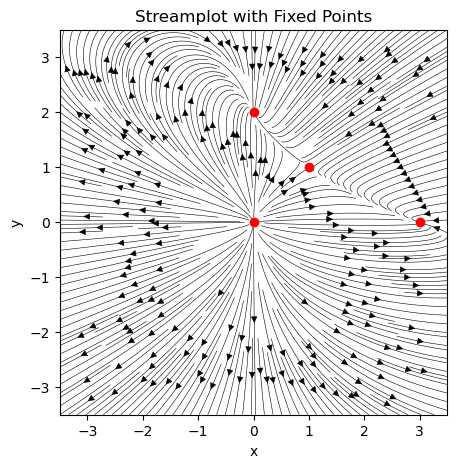

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Find numerical fixed points for the symbolic solutions you found earlier.
# You can start with these values (Slide 11), but feel free to change them to see what happens. **Hint:** Look at the sympy documentation for the `subs` method.

alpha_val = 3
beta_val = 1
gamma_val = 2
delta_val = 2

fixed_points_val = []
for x, y in fixed_points:
    x_val = float(x.subs({alpha: alpha_val, beta: beta_val, gamma: gamma_val, delta: delta_val}))
    y_val = float(y.subs({alpha: alpha_val, beta: beta_val, gamma: gamma_val, delta: delta_val}))
    fixed_points_val.append((x_val, y_val))


# Step 2: Generate streamplot of the vector field defined by the equations above. **Hint:** Look at the matplotlib documentation for the `streamplot` function.
X, Y = np.meshgrid(np.linspace(-3.5, 3.5, 40), np.linspace(-3.5, 3.5, 40))

U = alpha_val * X - beta_val * X**2 - gamma_val * X * Y
V = delta_val * Y - Y**2 - X * Y

plt.figure(figsize=(5, 5))
plt.streamplot(X, Y, U, V, color='k', density=3, linewidth=.4, zorder=1)

# Step 3: Overlay fixed points onto the streamplot from
for point in fixed_points_val:
    plt.scatter(point[0], point[1], color='red')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Streamplot with Fixed Points')
plt.show()


## Section 2: Stability of Fixed Points

Using the same system as above, look at the stability of the fixed points.

1. Find the fixed points of the system (i.e., Task 1 above).
1. Define the Jacobian matrix of the system.
2. Find its eigenvalues at each fixed point.
3. Determine the stability (see Lecture 5, Slide 8).

The Jacobian matrix is given by:

$$
J = \begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} \\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y}
\end{bmatrix}
$$


In [3]:
# 1. Find Fixed Points (Same as above)
x, y = symbols('x y')

# this time we will use explicit values for the parameters
alpha, beta, gamma, delta = 3, 1, 2, 2

f = alpha * x - beta * x**2 - gamma * x * y
g = delta * y - y**2 - x * y

fixed_points = solve((Eq(f, 0), Eq(g, 0)), (x, y))

In [4]:
# 2. Create the Jacobian Matrix
# Hint: use Matrix and diff from sympy to compute the Jacobian matrix
from sympy import diff, Matrix


# Define the Jacobian matrix
J = Matrix([
    [diff(f, x), diff(f, y)], 
    [diff(g, x), diff(g, y)]
    ]) 
J

Matrix([
[-2*x - 2*y + 3,         -2*x],
[            -y, -x - 2*y + 2]])

In [5]:
def stability_type(J):
    """Method of direction fields to determine the stability type of a fixed point
    
    Args:
        J (numpy.ndarray): Jacobian matrix
    """
    # if the jacobian is sympy.Matrix, convert it to numpy.ndarray
    if isinstance(J, Matrix):
        J = np.array(J.tolist()).astype(np.float64)
    
    # Compute the trace and determinant of the Jacobian matrix    

    tau = np.trace(J)
    delta = np.linalg.det(J)
    
    if delta < 0:
        return "saddle point"
    elif delta > 0 and tau == 0:
        return "center"
    elif delta > 0 and tau != 0:
        if tau > 0:
            if tau**2 - 4*delta < 0:
                return "unstable spiral"
            else:
                return "unstable node"
        elif tau < 0:
            if tau**2 - 4*delta < 0:
                return "stable spiral"
            else:
                return "stable node"
    else:
        return "Unknown"

In [6]:
# 3. Compute eigenvalues for each fixed point 
# we substitute the x and y values into the Jacobian matrix and compute the eigenvalues

for point in fixed_points:
    x_val, y_val = point
    J_at_point = J.subs({x: x_val, y: y_val})
    ev = J_at_point.eigenvals()
    # evs are returned as a dictionary, ev: multiplicity
    ev = list(ev.keys())
    print(f"{point}\t{stability_type(J_at_point)} \t  {ev}")

(0, 0)	unstable node 	  [3, 2]
(0, 2)	stable node 	  [-1, -2]
(1, 1)	saddle point 	  [-sqrt(2) - 1, -1 + sqrt(2)]
(3, 0)	stable node 	  [-1, -3]


## Section 3: An Application
Let's explore an economic model inspired by the Lotka-Volterra equations:

1. **Resource (r)**: Represents a natural resource that grow at a constant rate $a$, e.g., grain.
2. **Producers (y)**: Companies consume the resource to produce output $y$, at an operational cost of $c$, e.g., labor costs.
3. **Production**: The resource is consumed at a rate $k$ — proportional to both current production $y$ and available resources $r$.


The model is described by the following differential equations:
$$
\frac{dr}{dt} = a r - k y r
$$
$$
\frac{dy}{dt} = k y r -c y
$$


### Task 1: Find the fixed points and the eigenvalues of the Jacobian matrix

What do we learn from these eigenvalues?

In [7]:
from sympy import symbols, Eq, solve, Matrix

r, y = symbols('r y')
a, k, c = 2, 1, 1

# Define the differential equations
dr_dt = a*r - k*y*r
dy_dt = -c*y + k*y*r

fixed_points = solve((dr_dt, dy_dt), (r, y))

# Define the Jacobian matrix
J = Matrix([[dr_dt.diff(r), dr_dt.diff(y)], [dy_dt.diff(r), dy_dt.diff(y)]])

for point in fixed_points:
    J_at_point = J.subs({r: point[0], y: point[1]})
    eigenvalues = J_at_point.eigenvals()
    print(f"Fixed point at {point}: Eigenvalues {eigenvalues}")


Fixed point at (0, 0): Eigenvalues {2: 1, -1: 1}
Fixed point at (1, 2): Eigenvalues {-sqrt(2)*I: 1, sqrt(2)*I: 1}


### Task 2: Plot the phase portrait

In [8]:
from scipy.integrate import odeint

In [9]:
def lv_system(x, t, a, k, c):
    R, Y = x
    dR_dt = a*R - k*Y*R
    dY_dt = -c*Y + k*Y*R
    return [dR_dt, dY_dt]

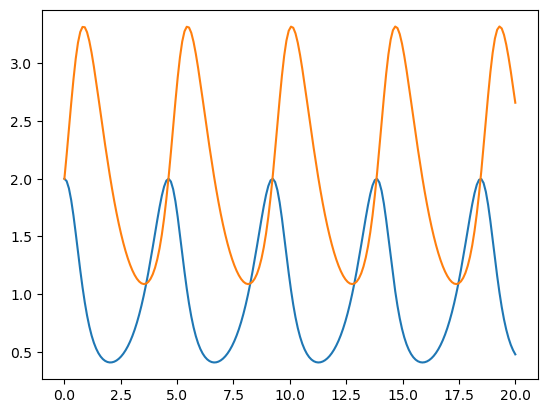

In [10]:
t = np.linspace(0, 20, 200)
yy = odeint(lv_system, y0=[2, 2], t=t, args=(a, k, c))

plt.plot(t, yy[:, 0], label='R')
plt.plot(t, yy[:, 1], label='Y')

Text(0, 0.5, 'Production (y)')

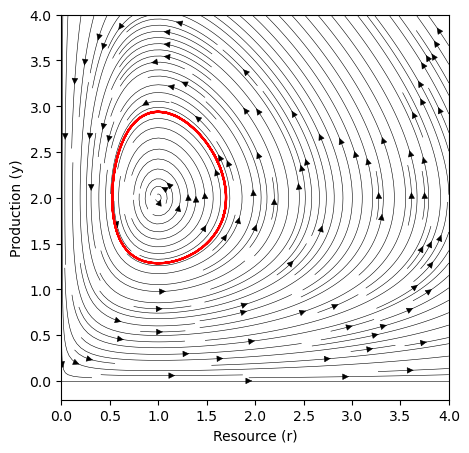

In [11]:
# plot streamplot

X, Y = np.meshgrid(np.linspace(0, 4, 20), np.linspace(0, 4, 20))
U, V = lv_system([X, Y], t, a, k, c)

plt.figure(figsize=(5, 5))
plt.streamplot(X, Y, U, V, color='k', density=2, linewidth=.4, zorder=1)

yy = odeint(lv_system, y0=[1.5,1.5], t=t, args=(a, k, c))
plt.plot(yy[:, 0], yy[:, 1], color='red', label='Trajectory')

plt.xlabel('Resource (r)')
plt.ylabel('Production (y)')